<a href="https://colab.research.google.com/github/DiyaSingla1012/Assignment6/blob/main/Assgn6_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Shape: (1000, 6)


,arrival_rate,service_rate,capacity,sim_time,avg_wait,max_wait
0,1.895421,2.856533,1,521.459001,0.869578,5.827800
1,9.264797,4.264466,3,487.144618,0.117193,1.508105
2,4.379888,2.039962,1,912.531146,253.174698,507.569483
3,1.331774,3.024264,5,634.519924,0.000000,0.000000
4,4.110547,5.213626,5,973.611668,0.000023,0.047519



MODEL COMPARISON TABLE


,Model,MSE,R2
8,XGBoost,292.356830,0.886013
9,MLP Neural Network,322.253380,0.874357
7,Extra Trees,337.383094,0.868458
1,Random Forest,492.905646,0.807821
2,Gradient Boosting,660.161493,0.742610
3,Decision Tree,748.106317,0.708321
6,AdaBoost,1293.249490,0.495775
0,Linear Regression,1600.953690,0.375804
4,KNN,2268.295629,0.115615
5,SVR,2920.239519,-0.138572



BEST MODEL
Model      XGBoost
MSE      292.35683
R2        0.886013
Name: 8, dtype: object


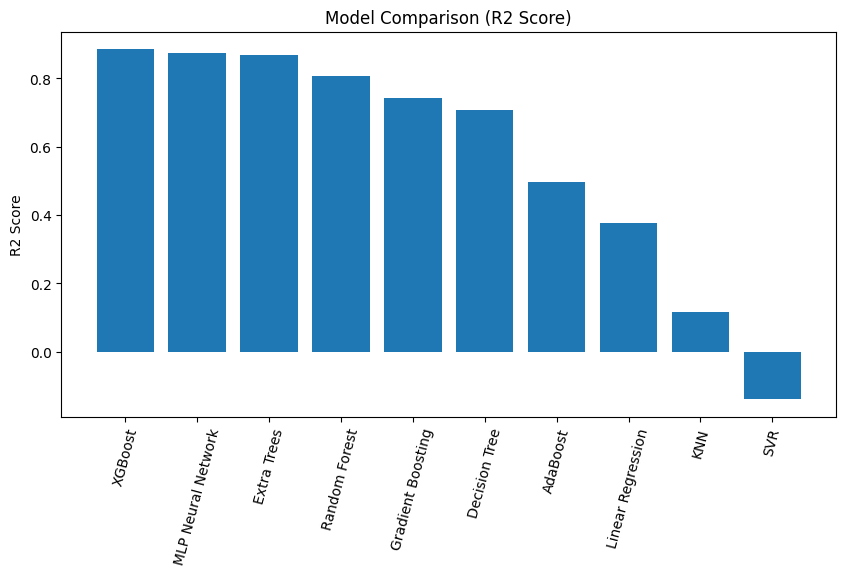

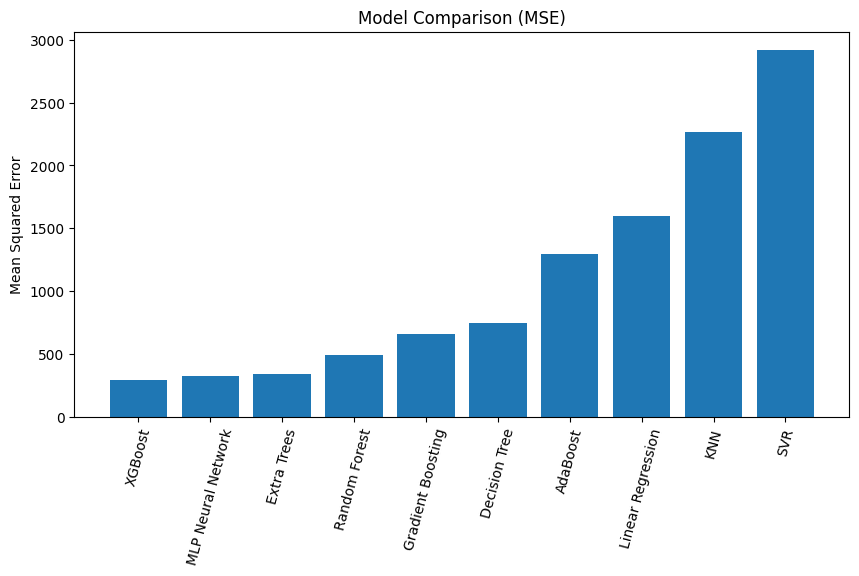

In [2]:

!pip install simpy xgboost -q

import simpy
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

import xgboost as xgb

def run_simulation(arrival_rate, service_rate, capacity, sim_time):
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=capacity)

    wait_times = []

    def customer(env):
        arrival_time = env.now
        with server.request() as req:
            yield req
            wait_times.append(env.now - arrival_time)
            yield env.timeout(random.expovariate(service_rate))

    def arrival_process(env):
        while True:
            yield env.timeout(random.expovariate(arrival_rate))
            env.process(customer(env))

    env.process(arrival_process(env))
    env.run(until=sim_time)

    return {
        "arrival_rate": arrival_rate,
        "service_rate": service_rate,
        "capacity": capacity,
        "sim_time": sim_time,
        "avg_wait": sum(wait_times)/len(wait_times) if wait_times else 0,
        "max_wait": max(wait_times) if wait_times else 0
    }

records = []

for i in range(1000):
    arrival_rate = random.uniform(1, 10)
    service_rate = random.uniform(1, 8)
    capacity = random.randint(1, 5)
    sim_time = random.uniform(100, 1000)

    result = run_simulation(arrival_rate, service_rate, capacity, sim_time)
    records.append(result)

df = pd.DataFrame(records)

print("Dataset Shape:", df.shape)
display(df.head())

X = df[["arrival_rate", "service_rate", "capacity", "sim_time"]]
y = df["avg_wait"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "KNN": KNeighborsRegressor(),
    "SVR": SVR(),
    "AdaBoost": AdaBoostRegressor(),
    "Extra Trees": ExtraTreesRegressor(),
    "XGBoost": xgb.XGBRegressor(objective="reg:squarederror"),
    "MLP Neural Network": MLPRegressor(max_iter=2000)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    results.append([name, mse, r2])

results_df = pd.DataFrame(results, columns=["Model", "MSE", "R2"])
results_df = results_df.sort_values(by="R2", ascending=False)

print("\nMODEL COMPARISON TABLE")
display(results_df)

best_model = results_df.iloc[0]
print("\nBEST MODEL")
print(best_model)

plt.figure(figsize=(10,5))
plt.bar(results_df["Model"], results_df["R2"])
plt.xticks(rotation=75)
plt.ylabel("R2 Score")
plt.title("Model Comparison (R2 Score)")
plt.show()

plt.figure(figsize=(10,5))
plt.bar(results_df["Model"], results_df["MSE"])
plt.xticks(rotation=75)
plt.ylabel("Mean Squared Error")
plt.title("Model Comparison (MSE)")
plt.show()